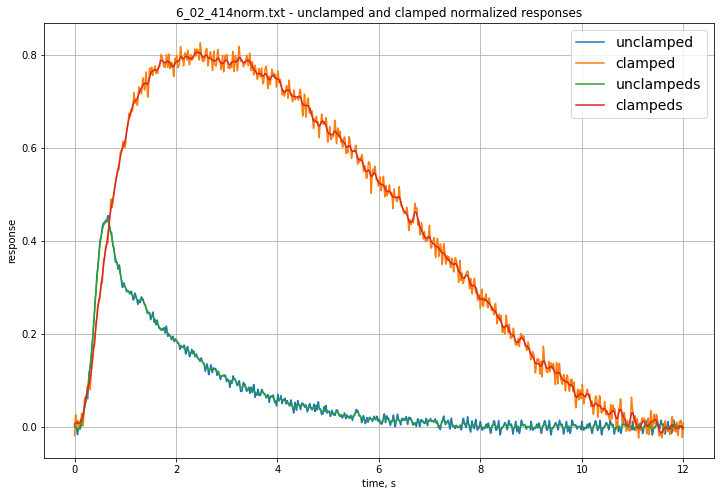

In [85]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, optimize

#v. 20231114.1

input_dir = "./data/pde-extraction/"
output_dir = "./output/pde-extraction/"
filename = "6_02_414norm.txt"

unclamped = []
clamped = []
t = []
with open(input_dir + filename, 'r', encoding='utf-8') as file:
    for line in file:
        r0, r1, r2 = (float('0' if num == '.' else num) for num in line.split())
        unclamped.append(r0)
        clamped.append(r1)
        t.append(r2)
unclamped = np.array(unclamped)
clamped = np.array(clamped)
t = np.array(t)

# https://support.ptc.com/help/mathcad/r8.0/ru/index.html#page/PTC_Mathcad_Help/gaussian_kernel_smoothing.html#wwID0ELY5U
# unclampeds = gaussian_filter1d(unclamped, sigma=0.37)
# clampeds = gaussian_filter1d(clamped, sigma=0.37)

fig, ax = plt.subplots()
ax.plot(t, clamped, label='clamped')
ax.plot(t, unclamped, label='unclamped')
# ax.plot(t, unclampeds, 'g', label='unclampeds')
# ax.plot(t, clampeds, 'g', label='clampeds')
fig.set_figwidth(12)
fig.set_figheight(8)
ax.set_title(f'{filename} - unclamped and clamped normalized responses')
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.legend(prop={"size": 14})
ax.grid()

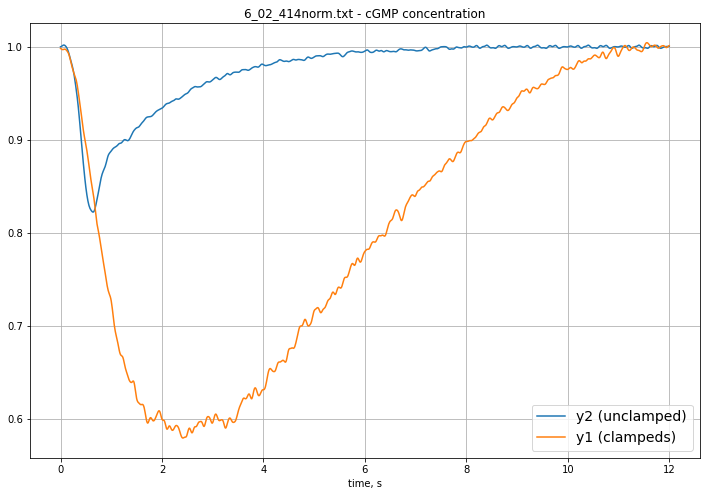

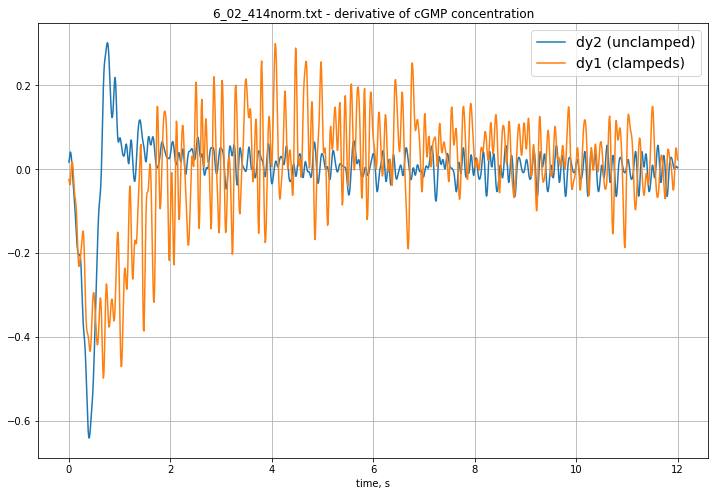

In [86]:
h = 3   # channels's cooperativity
y1 = (1 - clamped) ** (1 / h)
y2 = (1 - unclamped) ** (1 / h)

fig, ax = plt.subplots()
ax.plot(t, y1, label='y1 (clamped)')
ax.plot(t, y2, label='y2 (unclamped)')
fig.set_figwidth(12)
fig.set_figheight(8)
ax.set_title(f'{filename} - cGMP concentration')
ax.set_xlabel('time, s')
ax.legend(prop={"size": 14})
ax.grid()

dy1 = np.gradient(y1, t[1] - t[0])
dy2 = np.gradient(y2, t[1] - t[0])

fig, ax = plt.subplots()
ax.plot(t, dy1, label='dy1 (clamped)')
ax.plot(t, dy2, label='dy2 (unclamped)')
fig.set_figwidth(12)
fig.set_figheight(8)
ax.set_title(f'{filename} - derivative of cGMP concentration')
ax.set_xlabel('time, s')
ax.legend(prop={"size": 14})
ax.grid()

a0 = 18650.985, a1 = 1.882, a2 = 1.881, a3 = 0.169, r_squared = 0.981


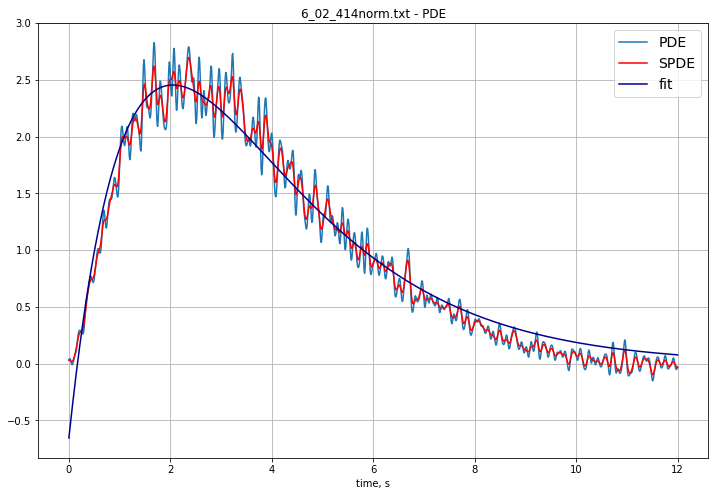

In [87]:
betad = 3.5 #+ 2.247
alpha = betad
beta = (alpha - dy1) / y1 - betad
PDE = beta
SPDE = gaussian_filter1d(PDE, sigma=3)

def func(t, a0, a1, a2, a3):
    return a0 * (np.exp(-(t - a3) / a1) - np.exp(-(t - a3) / a2))

popt = [200, 1, 1, 0.05]
try:
    popt, pcov = optimize.curve_fit(func, t, PDE, popt)
except RuntimeError:
    print('Не удалось выполнить аппроксимацию. Подберите начальные коэффициенты.')
a0, a1, a2, a3 = popt
fit = func(t, *popt)
rvalue = stats.linregress(PDE, fit).rvalue
r_squared = rvalue ** 2
print(f'a0 = {a0:.3f}, a1 = {a1:.3f}, a2 = {a2:.3f}, a3 = {a3:.3f}, r_squared = {r_squared:.3f}')

fig, ax = plt.subplots()
ax.plot(t, PDE, label='PDE')
ax.plot(t, SPDE, color='r', label='smoothed')
ax.plot(t, fit, color='darkblue', label='fit')
fig.set_figwidth(12)
fig.set_figheight(8)
ax.set_title(f'{filename} - PDE')
ax.set_xlabel('time, s')
ax.legend(prop={"size": 14})
ax.grid()

In [88]:
with open(f'{output_dir}{filename[:-4]}PDE.txt', 'w', encoding='utf-8') as file:
    for value in PDE:
        file.write(f'{value}\n')
with open(f'{output_dir}{filename[:-4]}SPDE.txt', 'w', encoding='utf-8') as file:
    for value in SPDE:
        file.write(f'{value}\n')